In [1]:

import random
import pandas as pd
import numpy as np
import awkward as ak
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
import json
from sklearn.metrics import classification_report, roc_auc_score
from scipy import interpolate
from sklearn.metrics import roc_curve, auc
from cycler import cycler
# from awkward import ak
import os

import uproot ## means uproot4
import sklearn.metrics as m

use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)


# env: HWW

In [2]:

CustNanoData = {
    
    'SingleMuon'   : "/data/bond/zhaoyz/Tree/Wcb_V2/2017/Merged/SingleMuon/Tree_SingleMuon.root",        
    'QCD'          : "/data/bond/zhaoyz/Tree/Wcb_V2/2017/Merged/MC/Tree_QCD.root",            
}
events = {typefile : {} for typefile in CustNanoData}
for typefile in CustNanoData:
    events[typefile] = uproot.lazy({CustNanoData[typefile]: "PKUTree" }) ## lazy means lazy computation style

In [3]:
MAIN_DIR = ".."

plot_dir = f"{MAIN_DIR}/plots/trigger/22May2024"
_ = os.system(f"mkdir -p {plot_dir}")

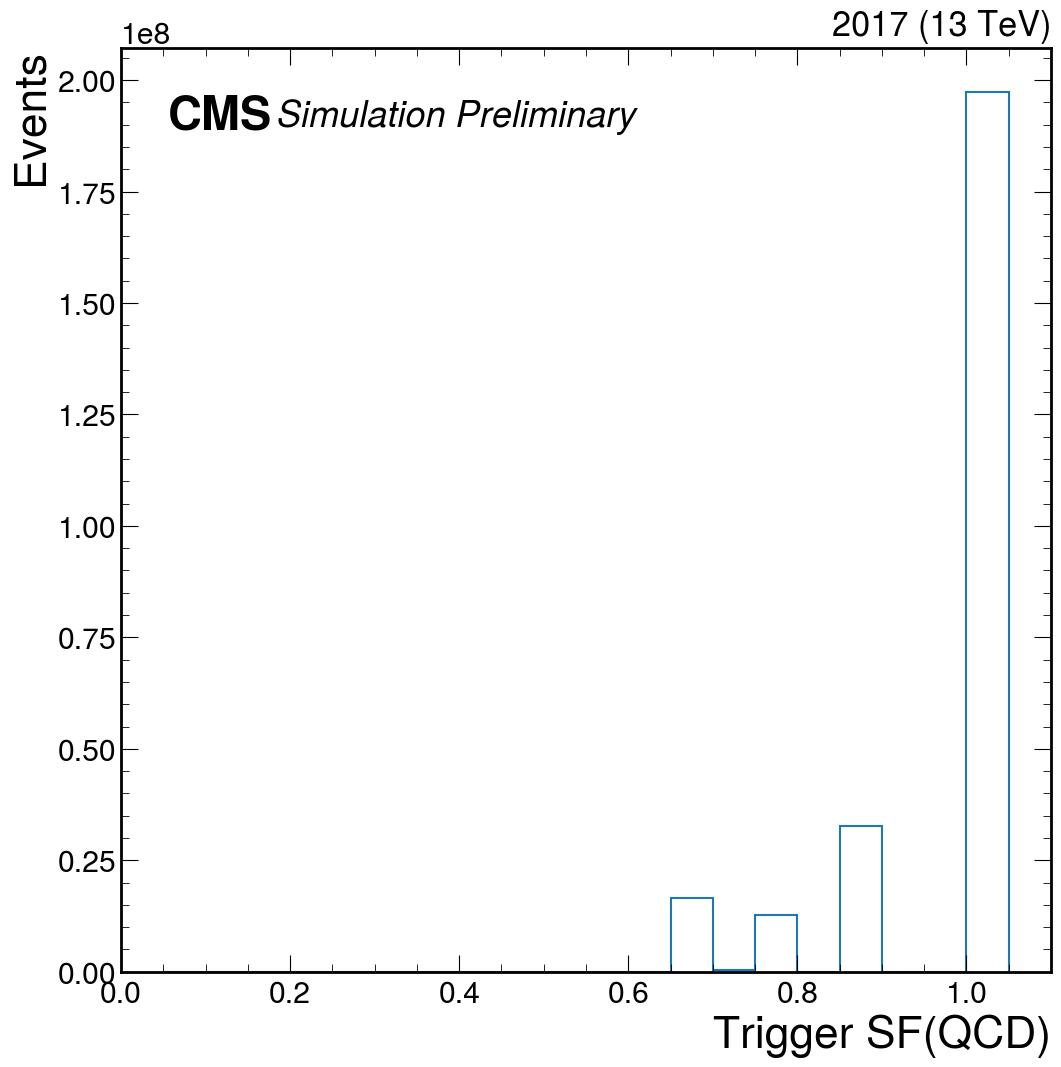

In [4]:
SFbins, SFmin, SFmax = 20, 0.05, 1.05
plt.figure(figsize=(12,12))
ax=plt.gca()
hep.cms.label(data= False, label = "Preliminary", year="2017", ax=ax, fontname='sans-serif', loc = 1)
hist1DSF = bh.Histogram(bh.axis.Regular(SFbins, SFmin, SFmax),storage=bh.storage.Weight())
eventsCut = events["QCD"][events["QCD"]["TriggerSF"] > 0.3]
hist1DSF.fill(eventsCut["TriggerSF"],weight = eventsCut["weight"])
h, err = hist1DSF.view().value, np.sqrt(hist1DSF.view().variance)
hep.histplot(h, bins=hist1DSF.axes[0].edges, yerr=err, histtype='step', stack=False)
plt.xlabel(r"Trigger SF(QCD)", fontsize=32, ha='right', x=1)
plt.ylabel(r"Events", fontsize=32, ha='right', y=1)
plt.savefig(f"{plot_dir}/2017QCDTriggerSF.pdf", bbox_inches='tight')
plt.show()

In [5]:
#Plot 2D trigger efficiency SFs uncertainty.
def SF2DUnc_withvalue(eventsMC,eventsData, x_label, y_label, isData = True, xmin = 200, xmax = 1200, bins = 500, legend_location='best'):
    if x_label == y_label: return
    """
    events: a dictionary, events.values() are collections of events
    """
    x_score, y_score = 'score_'+x_label, 'score_'+y_label
    # ax = plt.figure(figsize=(10,10))
    plt.figure(figsize=(15,12))
    ax=plt.gca()
    # fig ,ax = plt.subplots()
    hep.cms.label(data= isData, label = "Preliminary", year="2017", ax=ax, fontname='sans-serif')
    mmin = 30.0
    mmax = 230.0
    mbins = 20

    ptmin = 200.0
    ptmax = 600.0
    ptbins = 20
    
    hist2DMC = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DMC.fill(eventsMC["Mj_V2_a"],eventsMC["PTj_V2_a"],weight = eventsMC["weight"])

    eventsMC_Cut = eventsMC[ (eventsMC["HLT_PFJet500"] == True)  | (eventsMC["HLT_AK8PFJet500"] == True) | (eventsMC["HLT_AK8PFJet360_TrimMass30"] == True) | (eventsMC["HLT_PFHT1050"] == True) | (eventsMC["HLT_AK8PFJet380_TrimMass30"] == True) | (eventsMC["HLT_AK8PFJet400_TrimMass30"] == True) | (eventsMC["HLT_AK8PFJet420_TrimMass30"] == True) | (eventsMC["HLT_AK8PFHT750_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT800_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT850_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT900_TrimMass50"] == True)]
    
    hist2DMC_Cut = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DMC_Cut.fill(eventsMC_Cut["Mj_V2_a"],eventsMC_Cut["PTj_V2_a"],weight = eventsMC_Cut["weight"]*eventsMC_Cut["TriggerSF"])

    EffiMC2D = hist2DMC_Cut.view().value / hist2DMC.view().value



    hist2DData = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DData.fill(eventsData["Mj_V2_a"],eventsData["PTj_V2_a"])

    eventsData_Cut = eventsData[ (eventsData["HLT_PFJet500"] == True) | (eventsData["HLT_AK8PFJet500"] == True) | (eventsData["HLT_AK8PFJet360_TrimMass30"] == True) | (eventsData["HLT_PFHT1050"] == True) | (eventsData["HLT_AK8PFJet380_TrimMass30"] == True) | (eventsData["HLT_AK8PFJet400_TrimMass30"] == True) | (eventsData["HLT_AK8PFJet420_TrimMass30"] == True) | (eventsData["HLT_AK8PFHT750_TrimMass50"] == True) | (eventsData["HLT_AK8PFHT800_TrimMass50"] == True) | (eventsData["HLT_AK8PFHT850_TrimMass50"] == True) | (eventsData["HLT_AK8PFHT900_TrimMass50"] == True)]
    
    hist2DData_Cut = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DData_Cut.fill(eventsData_Cut["Mj_V2_a"],eventsData_Cut["PTj_V2_a"])

    EffiData2D = hist2DData_Cut.view().value / hist2DData.view().value


    Effi2DSF = EffiData2D/EffiMC2D

    #Start to calculate the uncentainty.
    Invera = 1./hist2DData_Cut.view().value
    Inverc = 1./hist2DData.view().value
    Inverb = 1./hist2DMC.view().value
    Inverd = 1./hist2DMC_Cut.view().value
    Sa = hist2DData_Cut.view().variance
    Sc = hist2DData.view().variance
    Sb = hist2DMC.view().variance
    Sd = hist2DMC_Cut.view().variance
                
    RelaUnc = np.sqrt( (Invera**2) * Sa + (Inverb**2) * Sb + (Inverc**2) * Sc + (Inverd**2) * Sd )
    Unc = Effi2DSF * RelaUnc

    #define mesh
    mesh = ax.pcolormesh(*hist2DMC.axes.edges.T, Unc.T , vmin = 0, vmax = 1 )
    xedges = hist2DMC.axes[0].edges
    # print(xedges)
    yedges = hist2DMC.axes[1].edges
    # print(yedges)
    h = Unc
    # print(h)
    meshed_value = []
    for i in range(len(xedges)-1):
        for j in range(len(yedges)-1):
            print("When mass = ",xedges[i]," pT = ", yedges[j],"SF = ",h[i,j])
            if h[i,j] >= 0 and h[i,j] <= 5: 
                SFij = h[i,j] 
            else : SFij = 1
            dict_tmp = {
                "mass":xedges[i],
                "pT"  :yedges[j],
                "SF"  :SFij
                }
            meshed_value.append(dict_tmp)
            # print(h[i,j])
            plt.text(xedges[i]+0.5*(xedges[i+1]-xedges[i]), yedges[j]+0.5*(yedges[j+1]-yedges[j]), round(h[i,j],2), color='white', ha='center', va='center',fontsize = 14)
    with open('mesh_data_2017_unc.json', 'w') as json_file:
        json.dump(meshed_value, json_file)
    cbar = plt.colorbar(mesh)
    cbar.set_label('Trigger efficiency scale factor uncertainty', rotation= 90,fontsize=32)
    # plt.title('Trigger efficiency scale factor', fontsize=32,color="black", x = 0.3, y = 0.9)

    plt.xlabel(r"Wcb candidate jet $m_{SD}$", fontsize=32, ha='right', x=1)
    plt.ylabel(r"Wcb candidate $p_{T}$", fontsize=32, ha='right', y=1)
    plt.savefig(f"{plot_dir}/2017Unc" + y_label + "_vs_" + x_label + "TriggerEffiSF.pdf", bbox_inches='tight')

    plt.show()

/tmp/ipykernel_361462/2763304984.py:29: RuntimeWarning: invalid value encountered in divide
  EffiMC2D = hist2DMC_Cut.view().value / hist2DMC.view().value
/tmp/ipykernel_361462/2763304984.py:41: RuntimeWarning: invalid value encountered in divide
  EffiData2D = hist2DData_Cut.view().value / hist2DData.view().value
/tmp/ipykernel_361462/2763304984.py:47: RuntimeWarning: divide by zero encountered in divide
  Invera = 1./hist2DData_Cut.view().value
/tmp/ipykernel_361462/2763304984.py:48: RuntimeWarning: divide by zero encountered in divide
  Inverc = 1./hist2DData.view().value
/tmp/ipykernel_361462/2763304984.py:49: RuntimeWarning: divide by zero encountered in divide
  Inverb = 1./hist2DMC.view().value
/tmp/ipykernel_361462/2763304984.py:50: RuntimeWarning: divide by zero encountered in divide
  Inverd = 1./hist2DMC_Cut.view().value
/tmp/ipykernel_361462/2763304984.py:56: RuntimeWarning: invalid value encountered in multiply
  RelaUnc = np.sqrt( (Invera**2) * Sa + (Inverb**2) * Sb + (In

When mass =  30.0  pT =  200.0 SF =  0.02855940062673121
When mass =  30.0  pT =  220.0 SF =  0.025883490480766557
When mass =  30.0  pT =  240.0 SF =  0.02643989269346826
When mass =  30.0  pT =  260.0 SF =  0.028311289123617557
When mass =  30.0  pT =  280.0 SF =  0.029284599319025034
When mass =  30.0  pT =  300.0 SF =  0.02642210075111865
When mass =  30.0  pT =  320.0 SF =  0.023320860164552884
When mass =  30.0  pT =  340.0 SF =  0.018384438904930463
When mass =  30.0  pT =  360.0 SF =  0.013459038511147898
When mass =  30.0  pT =  380.0 SF =  0.011157766861174537
When mass =  30.0  pT =  400.0 SF =  0.011953313541481471
When mass =  30.0  pT =  420.0 SF =  0.013736311776776693
When mass =  30.0  pT =  440.0 SF =  0.01629521811962713
When mass =  30.0  pT =  460.0 SF =  0.018385248774494708
When mass =  30.0  pT =  480.0 SF =  0.02087286603777914
When mass =  30.0  pT =  500.0 SF =  0.02251507204811343
When mass =  30.0  pT =  520.0 SF =  0.024684231575712503
When mass =  30.0  p

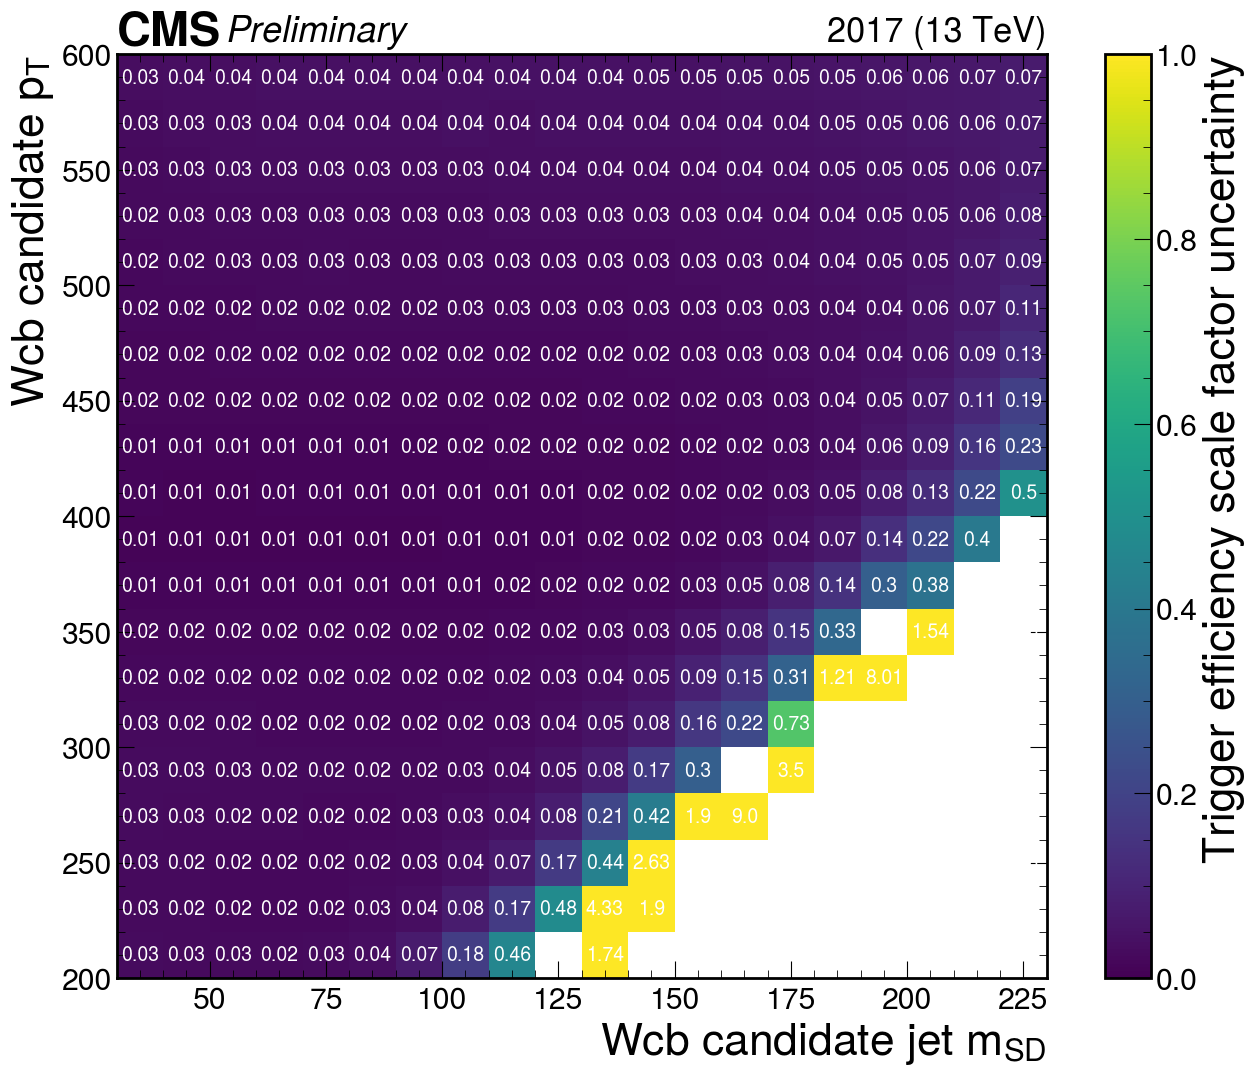

In [6]:
SF2DUnc_withvalue(eventsMC=events["QCD"], eventsData=events["SingleMuon"],x_label="Mja", y_label = "PTja",legend_location='lower right')

In [7]:
#Plot 2D trigger efficiency SFs., and with the text inside the bins.
def plot_effi_withvalue(eventsMC,eventsData, x_label, y_label, isData = True, xmin = 200, xmax = 1200, bins = 500, legend_location='best'):
    if x_label == y_label: return
    """
    events: a dictionary, events.values() are collections of events
    """
    x_score, y_score = 'score_'+x_label, 'score_'+y_label
    # ax = plt.figure(figsize=(10,10))
    plt.figure(figsize=(15,12))
    ax=plt.gca()
    # fig ,ax = plt.subplots()
    hep.cms.label(data= isData, label = "Preliminary", year="2017", ax=ax, fontname='sans-serif')
    mmin = 30.0
    mmax = 230.0
    mbins = 20

    ptmin = 200.0
    ptmax = 600.0
    ptbins = 20
    
    hist2DMC = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DMC.fill(eventsMC["Mj_V2_a"],eventsMC["PTj_V2_a"],weight = eventsMC["weight"])

    eventsMC_Cut = eventsMC[ (eventsMC["HLT_PFJet500"] == True)  | (eventsMC["HLT_AK8PFJet500"] == True) | (eventsMC["HLT_AK8PFJet360_TrimMass30"] == True) | (eventsMC["HLT_PFHT1050"] == True) | (eventsMC["HLT_AK8PFJet380_TrimMass30"] == True) | (eventsMC["HLT_AK8PFJet400_TrimMass30"] == True) | (eventsMC["HLT_AK8PFJet420_TrimMass30"] == True) | (eventsMC["HLT_AK8PFHT750_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT800_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT850_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT900_TrimMass50"] == True)]
    
    hist2DMC_Cut = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DMC_Cut.fill(eventsMC_Cut["Mj_V2_a"],eventsMC_Cut["PTj_V2_a"],weight = eventsMC_Cut["weight"]*eventsMC_Cut["TriggerSF"])

    EffiMC2D = hist2DMC_Cut.view().value / hist2DMC.view().value



    hist2DData = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DData.fill(eventsData["Mj_V2_a"],eventsData["PTj_V2_a"])

    eventsData_Cut = eventsData[ (eventsData["HLT_PFJet500"] == True) | (eventsData["HLT_AK8PFJet500"] == True) | (eventsData["HLT_AK8PFJet360_TrimMass30"] == True) | (eventsData["HLT_PFHT1050"] == True) | (eventsData["HLT_AK8PFJet380_TrimMass30"] == True) | (eventsData["HLT_AK8PFJet400_TrimMass30"] == True) | (eventsData["HLT_AK8PFJet420_TrimMass30"] == True) | (eventsData["HLT_AK8PFHT750_TrimMass50"] == True) | (eventsData["HLT_AK8PFHT800_TrimMass50"] == True) | (eventsData["HLT_AK8PFHT850_TrimMass50"] == True) | (eventsData["HLT_AK8PFHT900_TrimMass50"] == True)]
    
    hist2DData_Cut = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DData_Cut.fill(eventsData_Cut["Mj_V2_a"],eventsData_Cut["PTj_V2_a"])

    EffiData2D = hist2DData_Cut.view().value / hist2DData.view().value



    Effi2DSF = EffiData2D/EffiMC2D

    # mesh = ax.pcolormesh(*hist2DMC.axes.edges.T, Effi2DSF.T , vmin = 0, vmax = 1.5 )
    mesh = ax.pcolormesh(*hist2DMC.axes.edges.T, Effi2DSF.T, vmin = 0.8, vmax = 1.2 )
   
    xedges = hist2DMC.axes[0].edges
    # print(xedges)
    yedges = hist2DMC.axes[1].edges
    # print(yedges)
    h = Effi2DSF
    # print(h)

    meshed_value = []
    for i in range(len(xedges)-1):
        for j in range(len(yedges)-1):
            print("When mass = ",xedges[i]," pT = ", yedges[j],"SF = ",h[i,j])
            if h[i,j] >= 0 and h[i,j] <= 5: 
                SFij = h[i,j] 
            else : SFij = 1
            dict_tmp = {
                "mass":xedges[i],
                "pT"  :yedges[j],
                "SF"  :SFij
                }
            meshed_value.append(dict_tmp)
            # print(h[i,j])
            plt.text(xedges[i]+0.5*(xedges[i+1]-xedges[i]), yedges[j]+0.5*(yedges[j+1]-yedges[j]), round(h[i,j],2), color='white', ha='center', va='center',fontsize = 14)
    with open('mesh_data_2017.json', 'w') as json_file:
        json.dump(meshed_value, json_file)
    
    cbar = plt.colorbar(mesh)
    cbar.set_label('Trigger efficiency scale factor', rotation= 90,fontsize=32)
    # plt.title('Trigger efficiency scale factor', fontsize=3
    # 2,color="black", x = 0.35, y = 0.9)
    plt.xlabel(r"Wcb candidate jet $m_{SD}$", fontsize=32, ha='right', x=1)
    plt.ylabel(r"Wcb candidate $p_{T}$", fontsize=32, ha='right', y=1)
    # plt.savefig("./2DSFPlots/2017Max1p5" + y_label + "_vs_" + x_label + "TriggerEffiSF.pdf", bbox_inches='tight')
    plt.savefig(f"{plot_dir}/2017WithValue" + y_label + "_vs_" + x_label + "TriggerEffiSF.pdf", bbox_inches='tight')

    plt.show()

/tmp/ipykernel_361462/3930148514.py:29: RuntimeWarning: invalid value encountered in divide
  EffiMC2D = hist2DMC_Cut.view().value / hist2DMC.view().value
/tmp/ipykernel_361462/3930148514.py:41: RuntimeWarning: invalid value encountered in divide
  EffiData2D = hist2DData_Cut.view().value / hist2DData.view().value


When mass =  30.0  pT =  200.0 SF =  0.8337505973122895
When mass =  30.0  pT =  220.0 SF =  0.9136394036467533
When mass =  30.0  pT =  240.0 SF =  1.0327325369456495
When mass =  30.0  pT =  260.0 SF =  1.1974922517956839
When mass =  30.0  pT =  280.0 SF =  1.304417294075634
When mass =  30.0  pT =  300.0 SF =  1.285929793657107
When mass =  30.0  pT =  320.0 SF =  1.177040368912947
When mass =  30.0  pT =  340.0 SF =  0.96275047515922
When mass =  30.0  pT =  360.0 SF =  0.7524205087841789
When mass =  30.0  pT =  380.0 SF =  0.6598027892682743
When mass =  30.0  pT =  400.0 SF =  0.7299036478355982
When mass =  30.0  pT =  420.0 SF =  0.813380384082202
When mass =  30.0  pT =  440.0 SF =  0.8960894060386885
When mass =  30.0  pT =  460.0 SF =  0.9403636586971653
When mass =  30.0  pT =  480.0 SF =  0.9523088063304652
When mass =  30.0  pT =  500.0 SF =  0.9428057424547578
When mass =  30.0  pT =  520.0 SF =  0.9415798743446859
When mass =  30.0  pT =  540.0 SF =  0.959945269928688

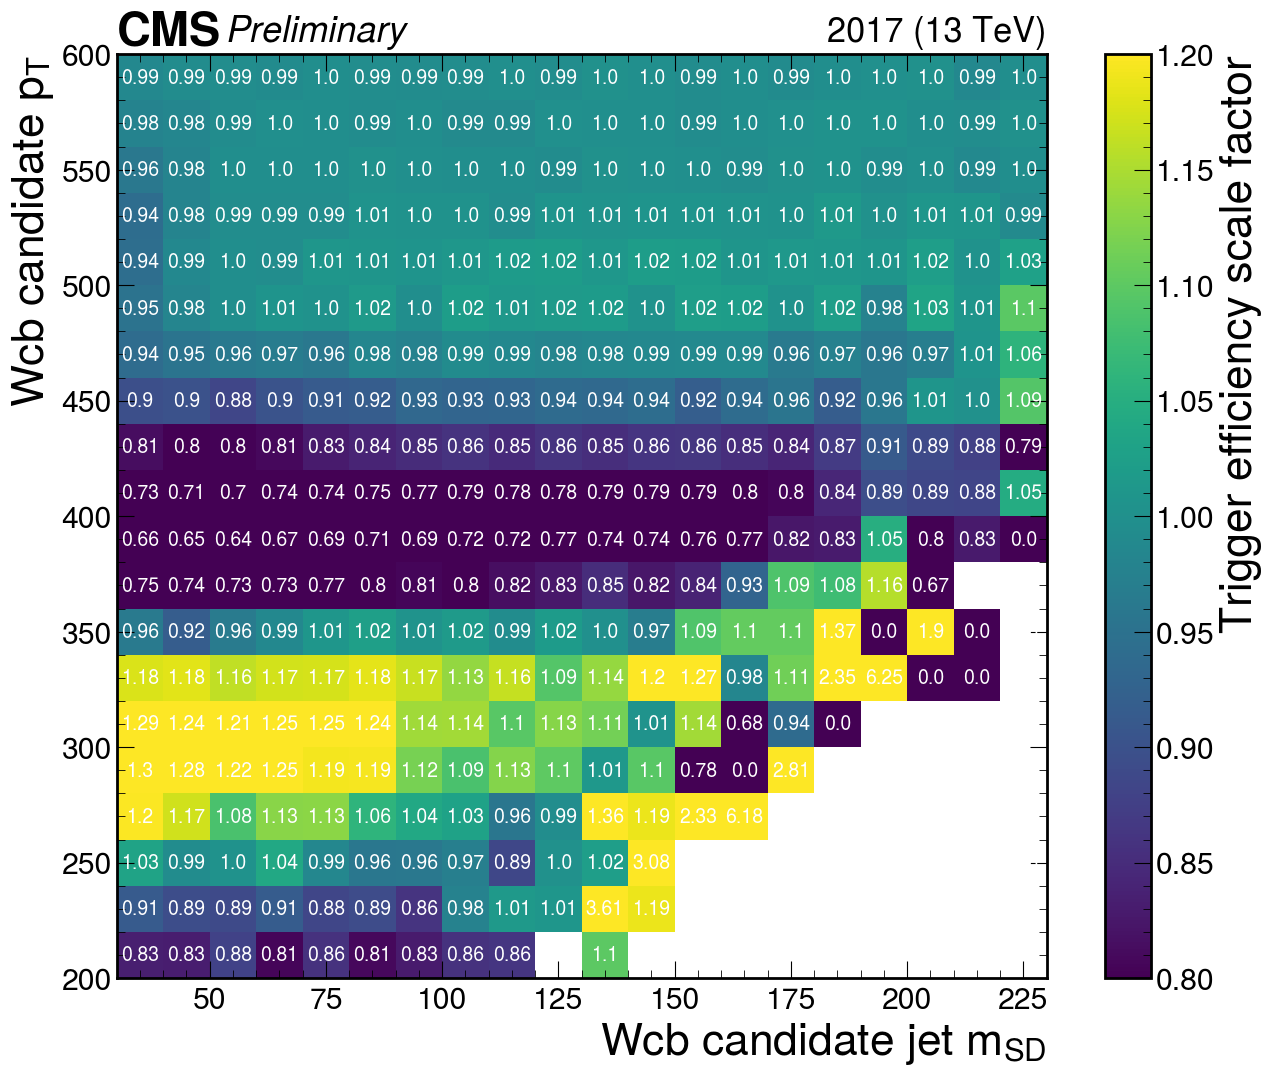

In [8]:
plot_effi_withvalue(eventsMC=events["QCD"], eventsData=events["SingleMuon"],x_label="Mja", y_label = "PTja",legend_location='lower right')

In [9]:
STOP_HERE

NameError: name 'STOP_HERE' is not defined

### (optional) plot the 2D trigger efficiency distributionm

In [ ]:
#Plot 2D trigger efficiency SFs.
def distri(eventsMC, x_label, y_label, isData = True, PassTrigger = True, xmin = 200, xmax = 1200, bins = 500, legend_location='best'):
    if x_label == y_label: return
    """
    events: a dictionary, events.values() are collections of events
    """
    x_score, y_score = 'score_'+x_label, 'score_'+y_label
    # ax = plt.figure(figsize=(10,10))
    plt.figure(figsize=(15,12))
    ax=plt.gca()
    # fig ,ax = plt.subplots()
    hep.cms.label(data= isData, label = "Preliminary", year="2017", ax=ax, fontname='sans-serif')
    mmin = 40.0
    mmax = 240.0
    mbins = 20

    ptmin = 200.0
    ptmax = 600.0
    ptbins = 20
    
    hist2D = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    eventsMC_Cut = eventsMC[ (eventsMC["HLT_PFJet500"] == True)  | (eventsMC["HLT_AK8PFJet500"] == True) | (eventsMC["HLT_AK8PFJet360_TrimMass30"] == True) | (eventsMC["HLT_PFHT1050"] == True) | (eventsMC["HLT_AK8PFJet380_TrimMass30"] == True) | (eventsMC["HLT_AK8PFJet400_TrimMass30"] == True) | (eventsMC["HLT_AK8PFJet420_TrimMass30"] == True) | (eventsMC["HLT_AK8PFHT750_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT800_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT850_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT900_TrimMass50"] == True)]

    if isData:
        if PassTrigger:     
            hist2D.fill(eventsMC_Cut["Mj_V2_a"],eventsMC_Cut["PTj_V2_a"])
            namestr = "./2DSFPlots/2017DataPass" + y_label + "_vs_" + x_label + ".pdf"
            Namesup = "JetHT(Pass Trigger Combination):"
        else:
            hist2D.fill(eventsMC["Mj_V2_a"],eventsMC["PTj_V2_a"])
            namestr = "./2DSFPlots/2017DataAll" + y_label + "_vs_" + x_label + ".pdf"
            Namesup = "JetHT(All):"
    else:
        if PassTrigger:
            hist2D.fill(eventsMC_Cut["Mj_V2_a"],eventsMC_Cut["PTj_V2_a"],weight = eventsMC_Cut["weight"]*eventsMC_Cut["TriggerSF"])
            namestr = "./2DSFPlots/2017QCDPass" + y_label + "_vs_" + x_label + ".pdf"
            Namesup = "QCD(Pass Trigger Combination):"
        else:
            hist2D.fill(eventsMC["Mj_V2_a"],eventsMC["PTj_V2_a"],weight = eventsMC["weight"])
            namestr = "./2DSFPlots/2017QCDAll" + y_label + "_vs_" + x_label + ".pdf"
            Namesup = "QCD(All):"
    mesh = ax.pcolormesh(*hist2D.axes.edges.T, hist2D.view().value.T )
    plt.colorbar(mesh)
    plt.xlabel(Namesup + r"Higgs candidate jet $m_{SD}$", fontsize=20, ha='right', x=1)
    plt.ylabel(Namesup + r"Higgs candidate $p_{T}$", fontsize=20, ha='right', y=1)
    plt.savefig(namestr, bbox_inches='tight')

    plt.show()

In [ ]:
distri(eventsMC=events["QCD"],isData = False, PassTrigger = True, x_label="Mja", y_label = "PTja",legend_location='lower right')
distri(eventsMC=events["QCD"],isData = False, PassTrigger = False, x_label="Mja", y_label = "PTja",legend_location='lower right')
distri(eventsMC=events["Data"],isData = True, PassTrigger = True, x_label="Mja", y_label = "PTja",legend_location='lower right')
distri(eventsMC=events["Data"],isData = True, PassTrigger = False, x_label="Mja", y_label = "PTja",legend_location='lower right')

In [ ]:
#Plot 2D trigger efficiency SFs.
def TriggerEff2D(eventsMC, x_label, y_label, isData = True, xmin = 200, xmax = 1200, bins = 500, legend_location='best'):
    if x_label == y_label: return
    """
    events: a dictionary, events.values() are collections of events
    """
    x_score, y_score = 'score_'+x_label, 'score_'+y_label
    # ax = plt.figure(figsize=(10,10))
    plt.figure(figsize=(15,12))
    ax=plt.gca()
    # fig ,ax = plt.subplots()
    hep.cms.label(data= isData, label = "Preliminary", year="2017", ax=ax, fontname='sans-serif')
    mmin = 40.0
    mmax = 240.0
    mbins = 20

    ptmin = 200.0
    ptmax = 600.0
    ptbins = 20

    if isData:
        eventsData = eventsMC

        hist2DData = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
        hist2DData.fill(eventsData["Mj_V2_a"],eventsData["PTj_V2_a"])

        eventsData_Cut = eventsData[ (eventsData["HLT_PFJet500"] == True) | (eventsData["HLT_AK8PFJet500"] == True) | (eventsData["HLT_AK8PFJet360_TrimMass30"] == True) | (eventsData["HLT_PFHT1050"] == True) | (eventsData["HLT_AK8PFJet380_TrimMass30"] == True) | (eventsData["HLT_AK8PFJet400_TrimMass30"] == True) | (eventsData["HLT_AK8PFJet420_TrimMass30"] == True) | (eventsData["HLT_AK8PFHT750_TrimMass50"] == True) | (eventsData["HLT_AK8PFHT800_TrimMass50"] == True) | (eventsData["HLT_AK8PFHT850_TrimMass50"] == True) | (eventsData["HLT_AK8PFHT900_TrimMass50"] == True)]

        hist2DData_Cut = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
        hist2DData_Cut.fill(eventsData_Cut["Mj_V2_a"],eventsData_Cut["PTj_V2_a"])

        Effi2D = hist2DData_Cut.view().value / hist2DData.view().value
        mesh = ax.pcolormesh(*hist2DData.axes.edges.T, Effi2D.T )
        
        xedges = hist2DData.axes[0].edges
        print(xedges)
        yedges = hist2DData.axes[1].edges
        print(yedges)
        h = Effi2D
        print(h)
        for i in range(len(xedges)-1):
            for j in range(len(yedges)-1):
                print(h[i,j])
                plt.text(xedges[i]+0.5*(xedges[i+1]-xedges[i]), yedges[j]+0.5*(yedges[j+1]-yedges[j]), round(h[i,j],2), color='white', ha='center', va='center',fontsize = 14)
        
        Namesup = "JetHT:"
        namestr = "./2DSFPlots_Updated_07052023/2017DataEffi2D" + y_label + "_vs_" + x_label + ".pdf"

    else:
   
        hist2DMC = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
        hist2DMC.fill(eventsMC["Mj_V2_a"],eventsMC["PTj_V2_a"],weight = eventsMC["weight"])
    
        eventsMC_Cut = eventsMC[ (eventsMC["HLT_PFJet500"] == True)  | (eventsMC["HLT_AK8PFJet500"] == True) | (eventsMC["HLT_AK8PFJet360_TrimMass30"] == True) | (eventsMC["HLT_PFHT1050"] == True) | (eventsMC["HLT_AK8PFJet380_TrimMass30"] == True) | (eventsMC["HLT_AK8PFJet400_TrimMass30"] == True) | (eventsMC["HLT_AK8PFJet420_TrimMass30"] == True) | (eventsMC["HLT_AK8PFHT750_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT800_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT850_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT900_TrimMass50"] == True)]
        
        hist2DMC_Cut = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
        hist2DMC_Cut.fill(eventsMC_Cut["Mj_V2_a"],eventsMC_Cut["PTj_V2_a"],weight = eventsMC_Cut["weight"]*eventsMC_Cut["TriggerSF"])
    
        Effi2D = hist2DMC_Cut.view().value / hist2DMC.view().value
        mesh = ax.pcolormesh(*hist2DMC.axes.edges.T, Effi2D.T )

        
        xedges = hist2DMC.axes[0].edges
        print(xedges)
        yedges = hist2DMC.axes[1].edges
        print(yedges)
        h = Effi2D
        print(h)
        
        for i in range(len(xedges)-1):
            for j in range(len(yedges)-1):
                print(h[i,j])
                plt.text(xedges[i]+0.5*(xedges[i+1]-xedges[i]), yedges[j]+0.5*(yedges[j+1]-yedges[j]), round(h[i,j],2), color='white', ha='center', va='center',fontsize = 14)
   

        Namesup = "QCD:"
        namestr = "./2DSFPlots_Updated_07052023/2017QCDEffi2D" + y_label + "_vs_" + x_label + ".pdf"





    # plt.title('2D-Trigger Efficiency', fontsize=32,color="black", x = 0.3, y = 0.9)
    cbar = plt.colorbar(mesh)
    cbar.set_label('Trigger efficiency', rotation= 90,fontsize=32)
    plt.xlabel(Namesup + r"Higgs candidate jet $m_{SD}$", fontsize=20, ha='right', x=1)
    plt.ylabel(Namesup + r"Higgs candidate $p_{T}$", fontsize=20, ha='right', y=1)
    plt.savefig(namestr, bbox_inches='tight')

    plt.show()

In [ ]:
TriggerEff2D(eventsMC=events["QCD"],isData = False,  x_label="Mja", y_label = "PTja",legend_location='lower right')


In [ ]:
TriggerEff2D(eventsMC=events["JetHT"],isData = True,  x_label="Mja", y_label = "PTja",legend_location='lower right')
